# Part 1: Launch a Duet Server and upload data

In [1]:
import syft as sy
duet = sy.duet(network_url="http://52.19.68.70:5000")

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://52.19.68.70:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!
♫♫♫ > Duet Server ID: e22d0fbaec9bfe339f4aaa58c7af83cf

♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.duet("e22d0fbaec9bfe339f4aaa58c7af83cf")

♫♫♫ > STEP 2: Ask your partner for their Client ID and enter it below!
♫♫♫ > Duet Partner's Client ID: a2e3078377de813a984bda2dc82ade85

♫♫♫ > Connecting...

♫♫♫ > CONNECTED!



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as m 
import seaborn as sns
np.random.seed(4567)

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


# we create some dicts to store losses
torch_loss_stats = {
    'torch loss train': [],
    'torch loss val': []
}

syft_loss_stats = {
    'syft loss train': [],
    'syft loss val': []
}

### Step.1. Dataset creation and preparation
We will generate a simple regression dataset y = a*x + b. with some gaussian noise.



#### 1.1. Generate synthetic dataset

In [3]:
n_samples = 500
x_ = np.sort(np.random.random(size=n_samples))

# create the true signal to be learned
coeff_ = 2
bias_ = 1
y_ = coeff_*x_ + bias_

# y = a*x + b with noise
wh_noise = np.random.normal(scale=10, size=n_samples)
y = y_  * wh_noise

#### 1.2. Split the dataset in training and validation
We will use 25% data points for validation and the rest for training.

In [4]:
val_pts = int(len(y)*0.25)

sample_idx = np.random.choice(range(0, len(y)), len(y))
training_idx, val_idx = sample_idx[val_pts:], sample_idx[:val_pts]

x_val, x = x_[val_idx], x_[training_idx]
y_val, y = y[val_idx], y[training_idx]

In [5]:
len(x_val), len(x)

(125, 375)

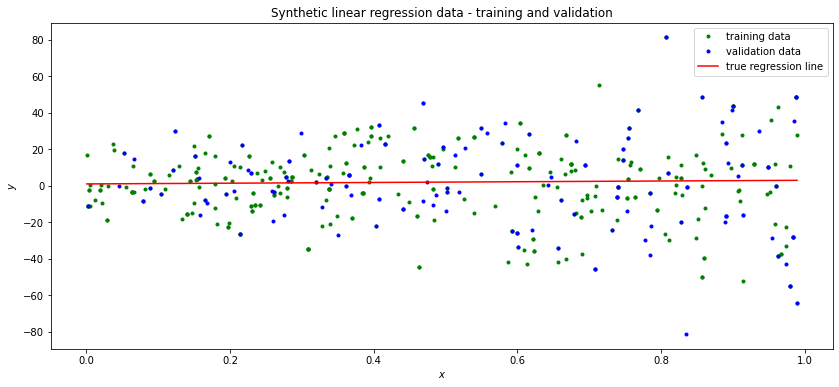

In [6]:
plt.figure(figsize=(14,6))
plt.title("Synthetic linear regression data - training and validation")
train, = plt.plot(x, y, '.', color='green', label='training data') 
val, = plt.plot(x_val, y_val, '.', color='blue', label='validation data') 
true_line, = plt.plot(x_, y_, color='red', label='true regression line') 
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend(handles=[train, val, true_line])
plt.show()

We have a syntethic regression dataset with gaussian multiplicative noise. 125 data points are for validation and 375 for training.

#### 1.3. Create PyTorch Dataset¶
We transform the numpy vectors into tensors.

In [7]:
x_train, y_train = torch.from_numpy(x.reshape(-1,1).astype('float32')), torch.from_numpy(y.reshape(-1,1).astype('float32'))
x_test, y_test =  torch.from_numpy(x_val.reshape(-1,1).astype('float32')), torch.from_numpy(y_val.reshape(-1,1).astype('float32'))
x_train.shape, y_train.shape

(torch.Size([375, 1]), torch.Size([375, 1]))

#### 1.4 Document the dataset

We need to add some valuable information for the data scientist

##### training dataset

In [8]:
x_train = x_train.tag("x_data_train")
x_train = x_train.describe("X Train - synthetic regression dataset")

y_train = y_train.tag("y_data_train")
y_train = y_train.describe("Y Train - synthetic regression dataset")

##### testing dataset

In [9]:
x_test = x_test.tag("x_data_test")
x_test = x_test.describe("X Test - synthetic regression dataset")

y_test = y_test.tag("y_data_test")
y_test = y_test.describe("Y Test - synthetic regression dataset")

#### 1.5 Send the dataset to the (network) store

In [10]:
x_train_ptr = x_train.send(duet, pointable=True) # we have to make it searchable
y_train_ptr = y_train.send(duet, pointable=True)

x_test_ptr = x_test.send(duet, pointable=True) # we have to make it searchable
y_test_ptr = y_test.send(duet, pointable=True)

In [11]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 48484ccdfd824753ab4615650e3b19fd>,[x_data_train],X Train - synthetic regression dataset,<class 'torch.Tensor'>
1,<UID: 80e284f551d74562a47b0f5d0485e606>,[y_data_train],Y Train - synthetic regression dataset,<class 'torch.Tensor'>
2,<UID: 48c985b098ea459f9f3e8f1fc2287779>,[x_data_test],X Test - synthetic regression dataset,<class 'torch.Tensor'>
3,<UID: b030dc0de3404c42a581a27427cc1263>,[y_data_test],Y Test - synthetic regression dataset,<class 'torch.Tensor'>


In [12]:
duet.requests.add_handler(
    action="accept",
    print_local=True,  # print the result in your notebook
)

[2021-09-30T14:54:16.530327+0000][CRITICAL][logger]][1671] > HANDLER Request <UID: 0e8eb9add2fd42f49a87eebd4d6cbae2>: To evaluate training progress
Value: <Storable: 446.00042724609375>
[2021-09-30T14:54:17.177551+0000][CRITICAL][logger]][1671] > HANDLER Request <UID: 2b4659557ad34453b2b97c316eee83fc>: To evaluate training progress
Value: <Storable: 445.6488037109375>
[2021-09-30T14:54:17.654218+0000][CRITICAL][logger]][1671] > HANDLER Request <UID: d5cbf485bb58413fb235a872a555d292>: To evaluate training progress
Value: <Storable: 445.3446350097656>
[2021-09-30T14:54:18.870023+0000][CRITICAL][logger]][1671] > HANDLER Request <UID: bf7c030a6df748dab1bf947ecd23a03f>: To evaluate training progress
Value: <Storable: 445.0885925292969>
[2021-09-30T14:54:20.026418+0000][CRITICAL][logger]][1671] > HANDLER Request <UID: 43090131cf4646898a0729bf3965d903>: To evaluate training progress
Value: <Storable: 444.8802795410156>
[2021-09-30T14:54:20.537577+0000][CRITICAL][logger]][1671] > HANDLER Reque

##### ------------------------------------------------------------------------------------------------

#### END DATA OWNER NOTEBOOK

In [3]:
data = th.FloatTensor(np.array([5, 15, 25, 35, 45, 55]).reshape(-1, 1))

data = data.tag("DO1 data")
data = data.describe("Dataset of 6 samples, 1 feature")

data_ptr = data.send(duet, searchable=True)

In [4]:
duet.store.pandas

,ID,Tags,Description
0,<UID: 95b50c81d41f48f280bfb4ed88ff3c62>,[DO1 data],"Dataset of 6 samples, 1 feature"


In [5]:
data

tensor([[ 5.],
        [15.],
        [25.],
        [35.],
        [45.],
        [55.]])

In [6]:
duet.requests.add_handler(
    action="accept",
    print_local=True,  # print the result in your notebook
)

> HANDLER Request : To evaluate training progress
Value: 1050.6131591796875
> HANDLER Request : To evaluate training progress
Value: 833.8958129882812
> HANDLER Request : To evaluate training progress
Value: 643.0696411132812
> HANDLER Request : To evaluate training progress
Value: 478.4125671386719
> HANDLER Request : To evaluate training progress
Value: 339.91876220703125
> HANDLER Request : To evaluate training progress
Value: 227.21815490722656
> HANDLER Request : To evaluate training progress
Value: 32.8933219909668
> HANDLER Request : To evaluate training progress
Value: 9.448577880859375
> HANDLER Request :
Value: [Parameter containing:
tensor([[0.6305]], requires_grad=True), Parameter containing:
tensor([1.1781], requires_grad=True)]
> HANDLER Request :
Value: in_features=1, out_features=1, bias=True
> HANDLER Request :
Value: OrderedDict([('weight', tensor([[0.6305]])), ('bias', tensor([1.1781]))])
